In [149]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [150]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [172]:
from replay import Replay, State, Team
from bots.lgbm.preprocessing    import remove_menu_and_pause
from bots.lgbm.preprocessing    import who_scored
from bots.lgbm.preprocessing    import game_state_to_numpy
from bots.lgbm.preprocessing    import transform_episode_around_pivot
from bots.lgbm.preprocessing    import Encoder
from bots.lgbm.preprocessing    import STACK_FRAMES

from typing import Optional
from sklearn.metrics import confusion_matrix, classification_report
from joblib import dump, load

import matplotlib.pyplot as plt
import numpy as np

In [152]:
def prepare_train_data(episodes, stack_frames=4):
    # Take resultative episodes as training data
    train_x, train_y = [], []
    for episode in episodes:
        scorer = who_scored(episode)
        if scorer is not None:
            if scorer == Team.Blue:
                transform_episode_around_pivot(episode, scorer)
            
            x = []
            y = []
            for e in episode:
                e_x, e_y = game_state_to_numpy(e, scorer)
                if e_x is not None and e_y is not None:
                    x.append(e_x)
                    y.append(e_y)
            
            # If there was no target player - ignore
            if x is not None and y is not None:
                train_x.append(x)
                train_y.append(y)
                
    # Stack n-frames
    x = []
    y = []
    for episode_i in range(len(train_x)):
        episode_x      = train_x[episode_i]
        episode_y      = train_y[episode_i]
        
        # Stacked samples
        train_sample = [episode_x[0] for _ in range(stack_frames)]
        
        x.append(np.concatenate(train_sample).ravel())
        y.append(Encoder.boolarr_to_class(np.array(episode_y[0])))
        
        for frame_i in range(1, len(episode_x)):
            frame_x = episode_x[frame_i]
            frame_y = episode_y[frame_i]
            
            # Move stack
            for i in range(1, stack_frames):
                train_sample[i] = train_sample[i - 1]
            train_sample[0] = frame_x
            
            x.append(np.concatenate(train_sample).ravel())
            y.append(Encoder.boolarr_to_class(np.array(frame_y)))
            
    return x, y

In [153]:
import os

def prepare_train_data_folder(path):
    all_episodes = []
    num_games    = 0
    for file in os.listdir(path):
        if file[-4:] != ".bin":
            continue
            
        num_games += 1
        
        # Parse replay and etract game epsiodes
        _, replay = Replay(open(os.path.join(path, file), mode="rb").read())
        episodes = remove_menu_and_pause(replay)
        all_episodes.extend(episodes)
        
    print("Num episodes: {}".format(len(all_episodes)))
    print("Num games: {}".format(num_games))
    return prepare_train_data(all_episodes, 1)

In [154]:
import json

with open("../preprocessed/statistics.json") as f:
    names = json.load(f)

In [155]:
max_replays = 0
max_name    = None
for name in names.keys():
    if len(names[name]) > max_replays:
        max_replays = len(names[name])
        max_name = name

In [156]:
max_replays

26

In [157]:
max_name

'Saviour'

In [158]:
all_episodes = []
for relative_path in names[max_name][:2]:
    path = ".."
    # Parse replay and etract game epsiodes
    _, replay = Replay(open(os.path.join(path, relative_path), mode="rb").read())
    episodes = remove_menu_and_pause(replay)
    all_episodes.extend(episodes)

In [159]:
len(all_episodes)

42

In [161]:
t1, t2 = prepare_train_data(all_episodes, STACK_FRAMES
del all_episodes

In [164]:
import lightgbm as lgb
imitator = lgb.LGBMClassifier(n_estimators=100)
mitator.fit(t1, t2)

In [166]:
imitator.feature_importances_

array([12171, 16939, 13405, 11485])

In [167]:
t2_pred = imitator.predict(t1)

In [168]:
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization


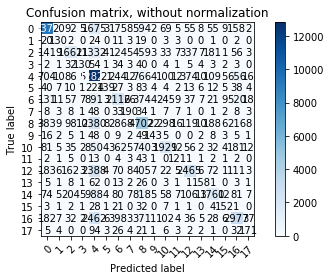

In [169]:
plot_confusion_matrix(t2, t2_pred.astype(int), list(range(18)))
plt.show()

In [170]:
# 100 estimators
print(classification_report(t2, t2_pred))

              precision    recall  f1-score   support

           0       0.83      0.76      0.79     12313
           1       0.56      0.60      0.58       218
           2       0.66      0.38      0.48      4375
           3       0.70      0.41      0.52       319
           4       0.49      0.80      0.61     15956
           5       0.69      0.22      0.34       622
           6       0.52      0.47      0.50      4486
           7       0.65      0.54      0.59       355
           8       0.49      0.54      0.51      8767
           9       0.71      0.48      0.57       299
          10       0.67      0.45      0.54      4315
          11       0.56      0.60      0.58       200
          12       0.68      0.42      0.52      5921
          13       0.66      0.55      0.60       286
          14       0.71      0.42      0.52      4234
          15       0.70      0.60      0.64       255
          16       0.59      0.45      0.51      6659
          17       0.60    

In [171]:
dump(imitator, 'imitator1.joblib')

['imitator1.joblib']